# Машинное обучение, РЭШ

## [Практическое задание 3. Градиентный спуск своими руками](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

### Общая информация
Дата выдачи: 14.11.2020

Мягкий дедлайн: 23:59MSK 21.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 23.11.2020

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания загружаются на my.nes. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 10!

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

**Задание 1 (2 балл)** Градиентного спуска;

**Задание 2 (3 балла)** Стохастического градиентного спуска;

Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [111]:
class LinearReg(BaseEstimator):
    def __init__(self, gd_type='full', 
                 tolerance=1e-6, max_iter=1000, w0=None, eta=1e-2, seed = 111):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
        self.seed = seed 

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        np.random.seed(self.seed)

        if (self.w0 == None):
          self.w0 = np.zeros(X.shape[1])

        self.w = self.w0
        self.loss_history = [self.calc_loss(X, y)]

        iter = 0
        need_to_continue = True

        while need_to_continue:
          
          if self.gd_type == 'full':
            step = self.calc_gradient(X,y)
            self.w -= self.eta*step
            need_to_continue = np.logical_and(iter <= self.max_iter,
                                            np.sqrt(np.mean(((self.eta*step)**2))) >= self.tolerance)
          elif self.gd_type == 'stochastic':
            i = np.random.randint(0,X.shape[0])
            step = self.eta * self.calc_gradient(X[i], y[i])
            # В качестве learning rate будем использовать (1/k)**alpha, где k - номер итерации (удовл. условию Роббинса-Монро)
            self.w -= step/((iter+1)**0.51)
            need_to_continue = np.logical_and(iter <= self.max_iter,
                                            np.sqrt(np.mean(((step/(iter+1))**2))) >= self.tolerance)
          else:
            raise Exception('The method {0} is not implemented yet'.format(self.gd_type))

          self.loss_history = np.append(self.loss_history, self.calc_loss(X, y))
          iter+=1
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return X @ self.w
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        return 2/X.shape[0] * np.dot(X.T, X@self.w - y)

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        return mean_squared_error(y, X @ self.w)


**Задание 3 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [82]:
#!pip install kaggle
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle competitions download -c nyc-taxi-trip-duration

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)


In [83]:
train = pd.read_csv('train.zip', parse_dates=['pickup_datetime'])
train['log_trip_duration'] = np.log1p(train['trip_duration']) 
train['p_date'] = train['pickup_datetime'].dt.date
train['p_date'] = train['p_date'].apply(lambda x: x.timetuple().tm_yday)
dtrain, dtest = train_test_split(train, test_size = 0.3, random_state = 0)

**Задание 4 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?


Далее мы будем обучать линейную модель (с константой), состоящую всего из одной вещественной переменной: p_date. Ведь наша задача посмотреть на сходимость, а не построить лучшую модель.

Нам надо отмасштабировать переменные обучающей выборки. При этом, необходимо запомнить параметры масштаба и применять их же для последующего масштабирования теста! 

In [84]:
X = dtrain['p_date']
y = np.array(dtrain['log_trip_duration'])

# Масштабируем
means = np.mean(X, axis=0)
sds = np.std(X, axis = 0)
X = (X-means)/sds

# И добавляем константу
X = np.c_[np.ones(X.shape[0]),X]

In [7]:
X_test = (dtest['p_date']-means)/sds
X_test = np.c_[np.ones(X_test.shape[0]),X_test]

Время обучения!

Решим задачу встроенными методами (точка отсчета):

In [117]:
regr = LinearRegression().fit(X, y)

print(regr.intercept_)
print(regr.coef_)

6.466887640016402
[0.         0.03783491]


Теперь наши:

In [119]:
# Full
full_gd = LinearReg(gd_type='full')
full_gd.fit(X,y)
print(full_gd.w)

y_test_pred = full_gd.predict(X_test)
print("Test MSE full = %.4f" % mean_squared_error(dtest['log_trip_duration'], y_test_pred))
print("Test R2 full = %.4f" % r2_score(dtest['log_trip_duration'], y_test_pred))

[6.46681911 0.03783451]
Test MSE full = 0.6282
Test R2 full = 0.0024


In [121]:
# Stochastic
stoch_gd = LinearReg(gd_type='stochastic', eta = 1)
stoch_gd.fit(X,y)
print(stoch_gd.w)

y_test_pred = stoch_gd.predict(X_test)
print("Test MSE stochastic = %.4f" % mean_squared_error(dtest['log_trip_duration'], y_test_pred))
print("Test R2 stochastic = %.4f" % r2_score(dtest['log_trip_duration'], y_test_pred))

[6.52921584 0.09017749]
Test MSE stochastic = 0.6347
Test R2 stochastic = -0.0079


Видим, что оба метода сошлись к похожим значениям на базовых параметрах. При этом R2 говорит, что модель так себе (ну мы и не ожидали многого от одной переменной). Еще видно, что полный градиент сошелся лучше (ближе к истинному значению). Не удивительно, ведь данных не очень много и полный градиент быстро сходится, пока случайный скачет около решения. Теперь давайте варьировать параметры:

In [95]:
for max_iters in range(500, 3500, 500):
  print('Number of iterations: %.f' % max_iters)
  full_gd = LinearReg(gd_type='full', max_iter = max_iters)
  full_gd.fit(X,y)
  y_test_pred = full_gd.predict(X_test)
  print("Test MSE full = %.4f" % mean_squared_error(dtest['log_trip_duration'], y_test_pred))
  print("Test R2 full = %.4f" % r2_score(dtest['log_trip_duration'], y_test_pred))

  stoch_gd = LinearReg(gd_type='stochastic', max_iter = max_iters)
  stoch_gd.fit(X,y)
  y_test_pred = stoch_gd.predict(X_test)
  print("Test MSE stochastic = %.4f" % mean_squared_error(dtest['log_trip_duration'], y_test_pred))
  print("Test R2 stochastic = %.4f" % r2_score(dtest['log_trip_duration'], y_test_pred))

  print('\n')

Number of iterations: 500
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.9187
Test R2 stochastic = -0.4590


Number of iterations: 1000
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.6347
Test R2 stochastic = -0.0079


Number of iterations: 1500
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.6568
Test R2 stochastic = -0.0431


Number of iterations: 2000
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.6568
Test R2 stochastic = -0.0431


Number of iterations: 2500
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.6568
Test R2 stochastic = -0.0431


Number of iterations: 3000
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.6568
Test R2 stochastic = -0.0431




Учитывая, что мы используем seed в SGD, для обоих методов есть определенное максимальное число итераций до остановки при текущих параметрах. До достижения этого количества мы обучаемся лучше (без учета случайной природы SGD). Дальнейшие увеличение параметра не имеет смысла (остановка по другому критерию). Выше видно, что после 1500 итераций изменений нет для SGD, а для полного - уже для 500+. Все ожидаемо. 

In [114]:
for etas in np.logspace(1, -5, num =7):
  print('Eta: %.5f' % etas)

Eta: 10.00000
Eta: 1.00000
Eta: 0.10000
Eta: 0.01000
Eta: 0.00100
Eta: 0.00010
Eta: 0.00001


In [116]:
for etas in np.logspace(0, -5, num =6):
  print('Eta: %.5f' % etas)
  full_gd = LinearReg(gd_type='full', eta = etas)
  full_gd.fit(X,y)
  y_test_pred = full_gd.predict(X_test)
  print("Test MSE full = %.4f" % mean_squared_error(dtest['log_trip_duration'], y_test_pred))
  print("Test R2 full = %.4f" % r2_score(dtest['log_trip_duration'], y_test_pred))

  stoch_gd = LinearReg(gd_type='stochastic', eta = etas)
  stoch_gd.fit(X,y)
  y_test_pred = stoch_gd.predict(X_test)
  print("Test MSE stochastic = %.4f" % mean_squared_error(dtest['log_trip_duration'], y_test_pred))
  print("Test R2 stochastic = %.4f" % r2_score(dtest['log_trip_duration'], y_test_pred))

  print('\n')

Eta: 1.00000
Test MSE full = 42.4542
Test R2 full = -66.4253
Test MSE stochastic = 0.6347
Test R2 stochastic = -0.0079


Eta: 0.10000
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 0.6826
Test R2 stochastic = -0.0841


Eta: 0.01000
Test MSE full = 0.6282
Test R2 full = 0.0024
Test MSE stochastic = 13.6539
Test R2 stochastic = -20.6850


Eta: 0.00100
Test MSE full = 1.3856
Test R2 full = -1.2006
Test MSE stochastic = 37.8378
Test R2 stochastic = -59.0936


Eta: 0.00010
Test MSE full = 28.6421
Test R2 full = -44.4891
Test MSE stochastic = 42.1521
Test R2 stochastic = -65.9454


Eta: 0.00001
Test MSE full = 40.8110
Test R2 full = -63.8156
Test MSE stochastic = 42.4441
Test R2 stochastic = -66.4092




Тут тоже все согласуется с интуицией: если сделать eta очень маленькой, то все шаги сильно сожмутся. Это не позволит нам сойтись к решению. Так на примере выше: чем меньше eta, тем раньше (с худшей моделью) мы останавливаемся, так как быстрее достигаем критерия остановы. В то же время слишком большая eta не позволяет сойтись вообще, так как шаги большые и нас швыряет. 

**Задание 5 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного и  стохастического градиентного спусков. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

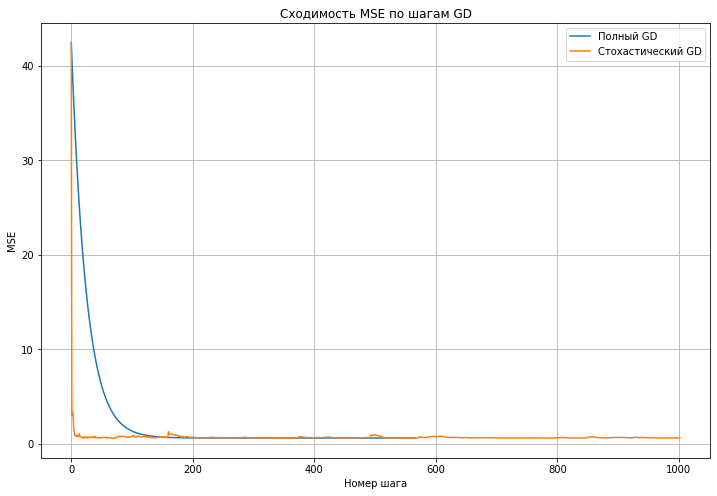

In [132]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(full_gd.loss_history, label = 'Полный GD')
ax.plot(stoch_gd.loss_history, label = 'Стохастический GD')
ax.set_title('Сходимость MSE по шагам GD')
ax.set_xlabel('Номер шага')
ax.set_ylabel('MSE')
ax.legend()

ax.grid(True)

Видно, что полный градиент сходится плавно, но надежно - критерий остановы достигается еще до 600 итерации. В то же время, стохастический градиент почти мгновенно скачет близко к оптимальным значениям, а потом скачет вокруг него (не сходясь окончательно). 


** Задание 6 (бонус) (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook

![picture](https://drive.google.com/uc?export=view&id=18K6yEtApR3L8hctQ8vWgau4oF2uYX1gN) 
